In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from branca.colormap import linear

## wykres 1 - szereg czasowy
Źródło: https://bdl.stat.gov.pl/bdl/dane/podgrup/wymiary/8/245/1754

In [2]:
DATA_PATH = "TRAN_1754_CTAB_20251205204430.csv"
df = pd.read_csv(DATA_PATH, sep=";")
df.head()

,Kod,Nazwa,wypadki ogółem;1999;[szt.],wypadki ogółem;2000;[szt.],wypadki ogółem;2001;[szt.],wypadki ogółem;2002;[szt.],wypadki ogółem;2003;[szt.],wypadki ogółem;2004;[szt.],wypadki ogółem;2005;[szt.],wypadki ogółem;2006;[szt.],...,wypadki ogółem;2016;[szt.],wypadki ogółem;2017;[szt.],wypadki ogółem;2018;[szt.],wypadki ogółem;2019;[szt.],wypadki ogółem;2020;[szt.],wypadki ogółem;2021;[szt.],wypadki ogółem;2022;[szt.],wypadki ogółem;2023;[szt.],wypadki ogółem;2024;[szt.],Unnamed: 28
0,0,POLSKA,NaN,57331.0,53799.0,53559.0,51078.0,51069.0,48100.0,46876.0,...,33664.0,32760.0,31674.0,30288.0,23540.0,22816.0,21322.0,20936.0,21519.0,NaN
1,200000,DOLNOŚLĄSKIE,NaN,3785.0,3552.0,3242.0,2960.0,2987.0,3149.0,3030.0,...,2324.0,2183.0,2148.0,1929.0,1578.0,1730.0,1869.0,1792.0,1883.0,NaN
2,201000,Powiat bolesławiecki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,84.0,52.0,63.0,53.0,55.0,33.0,35.0,40.0,60.0,NaN
3,201011,Bolesławiec (1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,22.0,NaN
4,201022,Bolesławiec (2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,7.0,NaN


In [3]:
value_cols = df.columns[3:-1]
value_cols

Index(['wypadki ogółem;2000;[szt.]', 'wypadki ogółem;2001;[szt.]',
       'wypadki ogółem;2002;[szt.]', 'wypadki ogółem;2003;[szt.]',
       'wypadki ogółem;2004;[szt.]', 'wypadki ogółem;2005;[szt.]',
       'wypadki ogółem;2006;[szt.]', 'wypadki ogółem;2007;[szt.]',
       'wypadki ogółem;2008;[szt.]', 'wypadki ogółem;2009;[szt.]',
       'wypadki ogółem;2010;[szt.]', 'wypadki ogółem;2011;[szt.]',
       'wypadki ogółem;2012;[szt.]', 'wypadki ogółem;2013;[szt.]',
       'wypadki ogółem;2014;[szt.]', 'wypadki ogółem;2015;[szt.]',
       'wypadki ogółem;2016;[szt.]', 'wypadki ogółem;2017;[szt.]',
       'wypadki ogółem;2018;[szt.]', 'wypadki ogółem;2019;[szt.]',
       'wypadki ogółem;2020;[szt.]', 'wypadki ogółem;2021;[szt.]',
       'wypadki ogółem;2022;[szt.]', 'wypadki ogółem;2023;[szt.]',
       'wypadki ogółem;2024;[szt.]'],
      dtype='object')

In [5]:
years = value_cols.str.extract(r';(\d{4});')[0].astype(int)
years[:5]

0    2000
1    2001
2    2002
3    2003
4    2004
Name: 0, dtype: int64

In [6]:
values = df.iloc[0, 3:-1].astype(int).values
values

array([57331, 53799, 53559, 51078, 51069, 48100, 46876, 49536, 49054,
       44196, 38832, 40131, 37062, 35847, 34970, 32967, 33664, 32760,
       31674, 30288, 23540, 22816, 21322, 20936, 21519])

In [7]:
ts = pd.DataFrame({"year": years, "accidents": values})
ts[:5]

,year,accidents
0,2000,57331
1,2001,53799
2,2002,53559
3,2003,51078
4,2004,51069


In [8]:
ts["accidents_k"] = ts["accidents"] / 1000
ts[:5]

,year,accidents,accidents_k
0,2000,57331,57.331
1,2001,53799,53.799
2,2002,53559,53.559
3,2003,51078,51.078
4,2004,51069,51.069


In [9]:
mean_val = ts["accidents_k"].mean()
mean_val

np.float64(38.517039999999994)

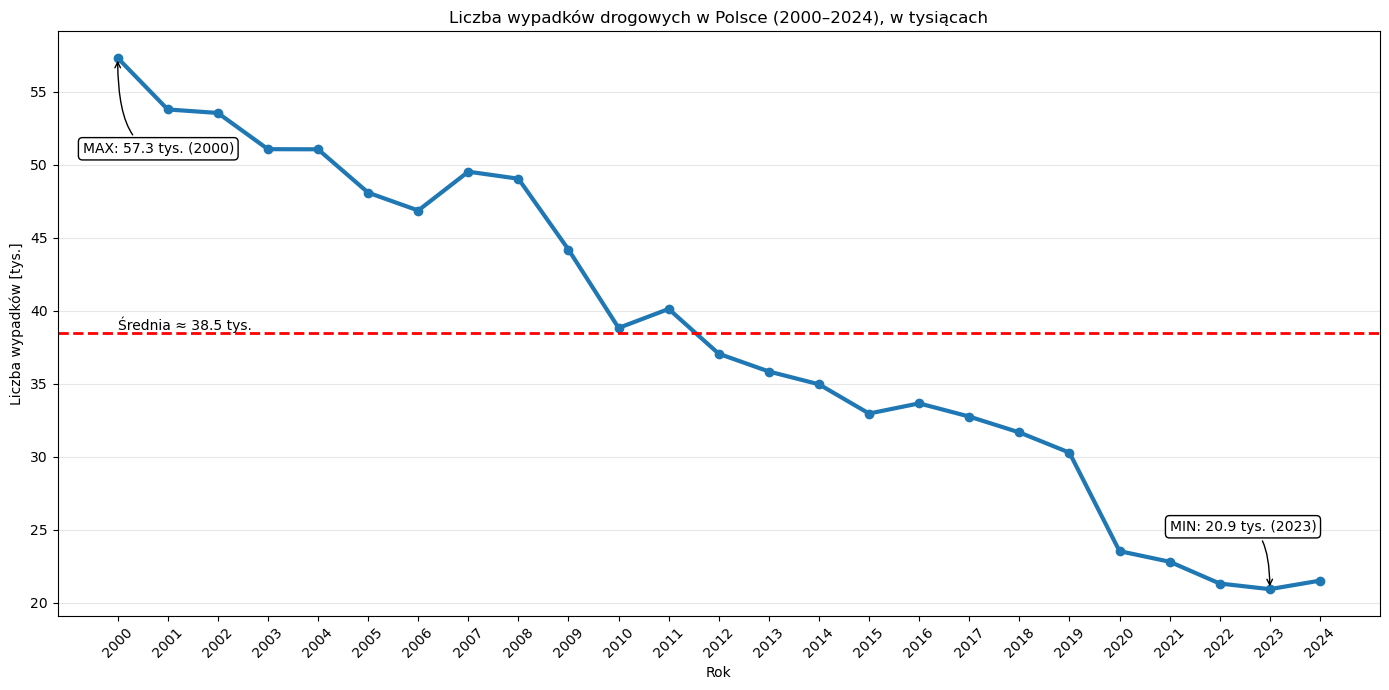

In [10]:
plt.figure(figsize=(14, 7))

plt.plot(ts["year"], ts["accidents_k"], linewidth=3, marker="o")

plt.axhline(mean_val, linestyle="--", linewidth=2, color='red')
plt.text(ts["year"].min(), mean_val,
         f"Średnia ≈ {mean_val:.1f} tys.",
         va="bottom", ha="left")

max_row = ts.loc[ts["accidents_k"].idxmax()]

plt.annotate(
    f'MAX: {max_row["accidents_k"]:.1f} tys. ({int(max_row["year"])})',
    xy=(max_row["year"], max_row["accidents_k"]),
    xytext=(max_row["year"]-0.7, max_row["accidents_k"]-6.5),
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        connectionstyle='angle3,angleA=0,angleB=-90'
    ),
    bbox=dict(facecolor='white', boxstyle='round', edgecolor='black')
)

min_row = ts.loc[ts["accidents_k"].idxmin()]

plt.annotate(
    f'MIN: {min_row["accidents_k"]:.1f} tys. ({int(min_row["year"])})',
    xy=(min_row["year"], min_row["accidents_k"]),
    xytext=(min_row["year"] - 2, min_row["accidents_k"] + 4),
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        connectionstyle='angle3,angleA=0,angleB=-90'
    ),
    bbox=dict(facecolor='white', boxstyle='round', edgecolor='black')
)

plt.title("Liczba wypadków drogowych w Polsce (2000–2024), w tysiącach")
plt.xlabel("Rok")
plt.ylabel("Liczba wypadków [tys.]")
plt.grid(axis='y',alpha=0.3)
plt.xticks(ts["year"], rotation=45)
plt.tight_layout()

plt.savefig('timeseries_wypadki.png')
plt.show()

## wykres 2 - kartogram
Źródło: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimated-road-traffic-death-rate-(per-100-000-population)

In [11]:
WHO_PATH = "who_traffic_death_rate.csv"

df = pd.read_csv(WHO_PATH, low_memory=False)
df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,RS_198,Estimated road traffic death rate (per 100 000...,numeric,GLOBAL,Global,Country,HKG,"China, Hong Kong Special Administrative Region",Year,2021,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2024-04-14T22:00:00.000Z
1,RS_198,Estimated road traffic death rate (per 100 000...,numeric,GLOBAL,Global,Country,MAC,"China, Macao Special Administrative Region",Year,2021,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2024-04-14T22:00:00.000Z
2,RS_198,Estimated road traffic death rate (per 100 000...,numeric,EUR,Europe,Country,MCO,Monaco,Year,2021,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2024-04-14T22:00:00.000Z
3,RS_198,Estimated road traffic death rate (per 100 000...,numeric,WPR,Western Pacific,Country,NIU,Niue,Year,2021,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2024-04-14T22:00:00.000Z
4,RS_198,Estimated road traffic death rate (per 100 000...,numeric,SEAR,South-East Asia,Country,MDV,Maldives,Year,2021,...,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,EN,2024-04-14T22:00:00.000Z


In [12]:
#only important columns
df = df[['SpatialDimValueCode', 'Location', 'Value']]
df = df.rename(columns={
    'SpatialDimValueCode': 'iso_a3',
    'Location': 'country',
    'Value': 'rate_per_100k'
})
df.head()

,iso_a3,country,rate_per_100k
0,HKG,"China, Hong Kong Special Administrative Region",0.0
1,MAC,"China, Macao Special Administrative Region",0.0
2,MCO,Monaco,0.0
3,NIU,Niue,0.0
4,MDV,Maldives,1.3


In [13]:
#Natural Earth shapefile
world = gpd.read_file("ne_10m_admin_0_countries.shp")
world = world.rename(columns={"ADM0_A3": "iso_a3"})
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [14]:
world["iso_a3"] = world["iso_a3"].str.upper().str.strip()
df["iso_a3"] = df["iso_a3"].str.upper().str.strip()

#merge data
world = world.merge(df, on="iso_a3", how="left")
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,country,rate_per_100k
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",Indonesia,11.3
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",Malaysia,13.9
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",Chile,10.3
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",Bolivia (Plurinational State of),17.6
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",Peru,12.7


In [16]:
# Folium map
m = folium.Map(tiles='cartodbpositron', zoom_start=2)

# Colormap
colormap = linear.YlOrRd_09.scale(
    world["rate_per_100k"].min(),
    world["rate_per_100k"].max()
)
colormap.caption = 'Wskaźnik śmiertelności wypadków drogowych na 100 tys. mieszkańców (2021)'

# GeoJson
folium.GeoJson(
    world.to_json(),
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['rate_per_100k'])
        if feature['properties'].get('rate_per_100k') is not None else 'lightgray',
        'color': 'black',
        'weight': 0.2,
        'fillOpacity': 0.8
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME', 'rate_per_100k'],
        aliases=['Kraj', 'Zgony na 100 tys.'],
        localize=True
    )
).add_to(m)

colormap.add_to(m)

m.save('choropleth_who_death_rate.html')
print("Saved choropleth_who_death_rate.html")

Saved choropleth_who_death_rate.html
